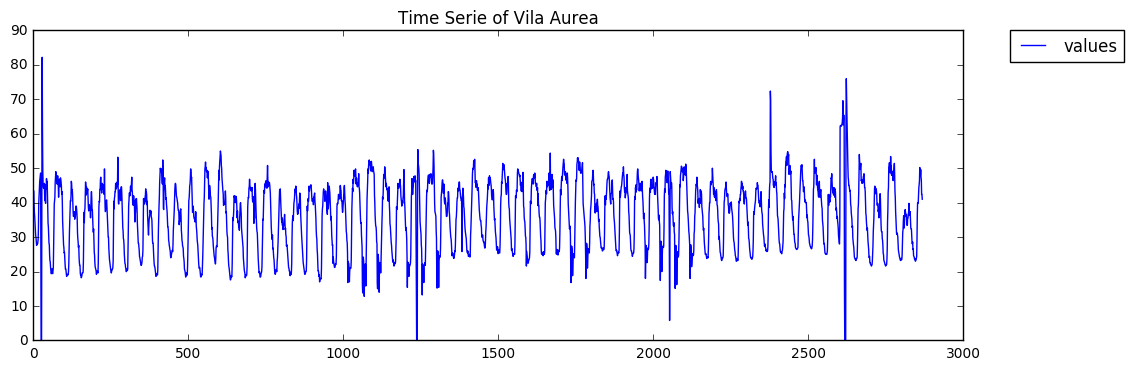

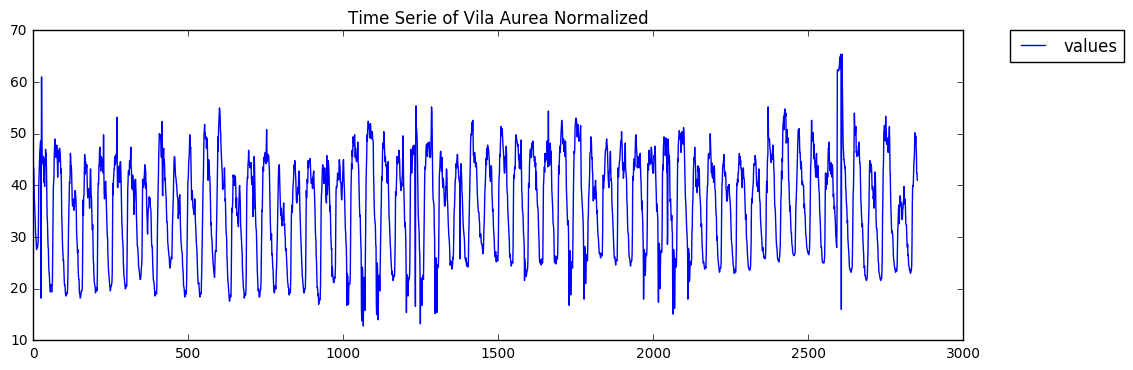

In [149]:
"""

This file provides a comparison between KNN and ARIMA model
at vilacarvalho-vazao-60.csv dataset. We evaluate both methods
in 60 and 30 

Author: Optimale
Date:   29-08-16

"""
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import time
import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error

# load the first dataset vilacarvalho-vazao-60
dataframe = pandas.read_csv('690a-vila-aurea-60d.csv', engine='python', skipfooter=3)
timeValues = dataframe['Time']
values     = dataframe['Value']

newV=[]
for i in values:
    if not i == 'null': 
        newV.append(float(i))

newV = np.array(newV)

timestamps=[]
for idx,i in enumerate(timeValues):
    # skipping null values
    if not values[idx] == 'null':
        val = time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
        timestamps.append([val])
        
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie of Vila Aurea')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

newV = reject_outliers(newV)

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie of Vila Aurea Normalized')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [150]:
# smoothing an array that represents the time serie.
def smooth(x, window_len=10, window='hanning'):


    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[2*x[0]-x[window_len:1:-1], x, 2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))

    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]


In [151]:
# convert an array of values into a dataset matrix
# dataset : numpy array that we want to convert to dataset
# look_back : number of previous time steps to use as input to predict the next one
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [152]:
# function to apply forecasting 
def forecasting(lastValue, classifier, size_forecasting=1):
    X = lastValue
    forecast = []
    
    for i in range(size_forecasting):
        result = classifier.predict([X])
        forecast.append(result[0])
        X = result
    
    return np.array(forecast)

In [153]:
# function to apply forecasting for LSTM network
def lstm_forecasting(lastValue, classifier, size_forecasting=1):
    X = lastValue
    forecast = []

    result = classifier.predict([X])
    forecast = [ item for item in result]

    return np.array(forecast)

In [154]:
train_size = int(len(newV) * 0.8)
test_size = len(newV) - train_size
train, test = newV[0:train_size], newV[train_size:train_size+test_size]
print(len(train), len(test))

(2282, 571)


In [155]:
# training the ARIMA Model
s = pd.Series(train, index=timeValues[0:train_size])

# build model
mod = sm.tsa.statespace.SARIMAX(s.values, trend='n', order=(1,1,1), seasonal_order=(0,1,1,24))
# fit the model
results = mod.fit()

In [156]:
forecasted = results.get_forecast(steps=24)

resultsForecast = forecasted.conf_int(alpha=0.05)
upper = resultsForecast.iloc[2:, 1]
lower = resultsForecast.iloc[2:, 0]
    
forecasted = (forecasted.predicted_mean)
newForecasted = []
for i in forecasted:
    newForecasted.append(i)

print("r2 score ARIMA = ",r2_score(test[:24],newForecasted))

('r2 score ARIMA = ', -3.5451672859418935)


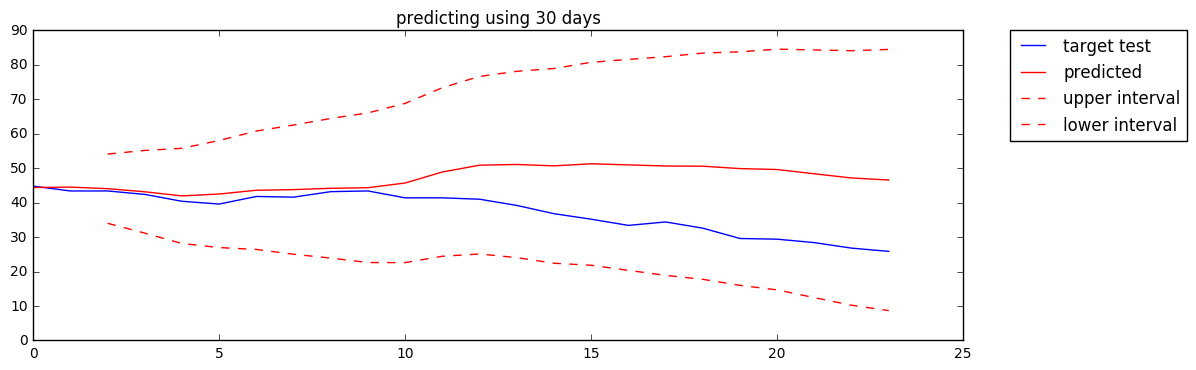

In [157]:
# shift train predictions for plotting
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = newForecasted

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test[0:24],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.plot(upper, color='r', label='upper interval', linestyle='--')
plt.plot(lower, color='r', label='lower interval', linestyle='--')
plt.title('predicting using 60 days')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [158]:
# Now, we'll train a LSTM model

scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstmTrain = scaler.fit_transform(train)
datasetLstmTest = scaler.fit_transform(test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [173]:
# Using LSTM
look_back = 23
trainX_lstm, trainY_lstm = create_dataset(datasetLstmTrain, look_back)
testX_lstm, testY_lstm = create_dataset(datasetLstmTest, look_back)
# reshape input to be [samples, time steps, features]
trainX_lstm = np.reshape(trainX_lstm, (trainX_lstm.shape[0], 1, trainX_lstm.shape[1]))
testX_lstm = np.reshape(testX_lstm, (testX_lstm.shape[0], 1, testX_lstm.shape[1]))

In [174]:
model = Sequential()
model.add(LSTM(10, input_dim=look_back))
model.add(Dense(1))
#if(os.path.isfile('model_weights.h5')):
#    model.load_weights('model_weights.h5')

#else:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX_lstm, trainY_lstm, nb_epoch=4, batch_size=1, verbose=1)
forecast_LSTM = lstm_forecasting(trainX_lstm[-25:],model,24)

Epoch 1/4
2258/2258 [==============================] - 11s - loss: 0.0081    
Epoch 2/4
2258/2258 [==============================] - 10s - loss: 0.0045    
Epoch 3/4
2258/2258 [==============================] - 10s - loss: 0.0039    
Epoch 4/4
2258/2258 [==============================] - 11s - loss: 0.0034    


In [175]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)
testY_lstm = scaler.inverse_transform(testY_lstm)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [176]:
#print(testY_lstm, forecast_LSTM)
print("r2 score LSTM = ",r2_score(testY_lstm[:25],forecast_LSTM))

('r2 score LSTM = ', 0.7086169785721137)


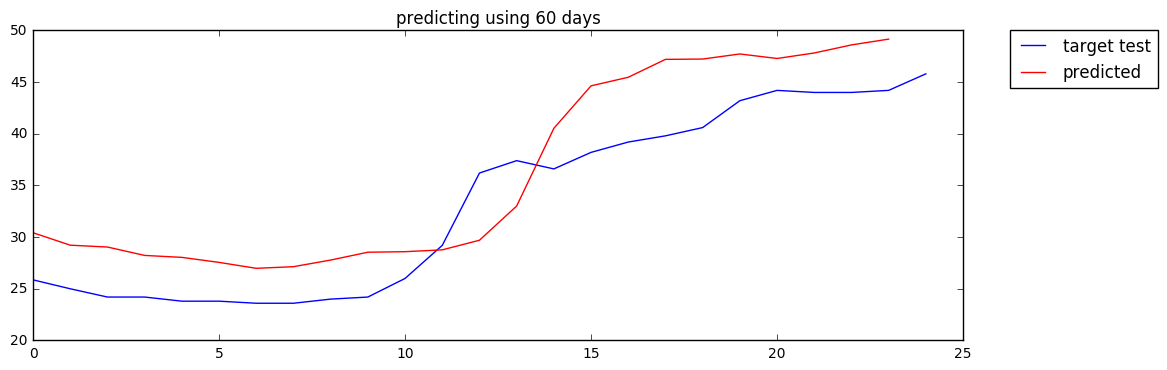

In [177]:
#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:-1]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY_lstm[:25],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting using 60 days')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [178]:
# training knn model
# Using  KNN
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [179]:
# train a classifier (not filtered)
clf_KNN = KNeighborsRegressor(n_neighbors=1, metric='manhattan')
clf_KNN.fit(trainX, trainY)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [180]:
forecast_KNN = forecasting(testX[0], clf_KNN, 24)

In [181]:
print("r2 score KNN = ",r2_score(testY[:24],forecast_KNN))

('r2 score KNN = ', 0.07507752833902448)


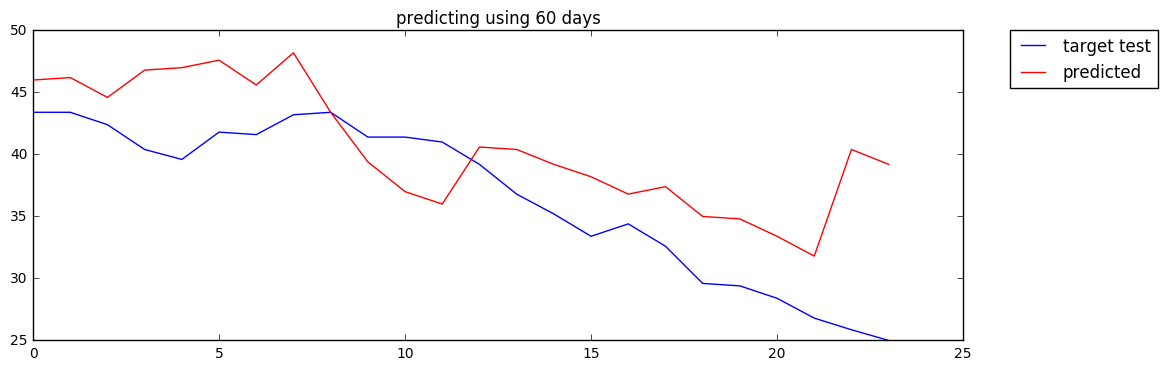

In [182]:
#plotting knn results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[0:24],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting using 60 days')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [183]:
arraylike_X = []
for i in trainX:
    arraylike_X.append(i[0])

arraylike_X=np.array(arraylike_X)
time_series_filtered_X = smooth(arraylike_X)
time_series_filtered_Y = smooth(trainY)
newX = []
for i in time_series_filtered_X:
    newX.append([i])

In [184]:
# train a classifier with smooth
clf = KNeighborsRegressor(n_neighbors=1,metric='manhattan')
clf.fit(newX,time_series_filtered_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [185]:
# metrics
arraylike_X = []
for i in testX:
    arraylike_X.append(i[0])
    
arraylike_X=np.array(arraylike_X)
time_series_filtered_X = smooth(arraylike_X)

newTestX = []
for i in time_series_filtered_X:
    newTestX.append([i])

# forecasting
result = forecasting(newTestX[0],clf,24)


('r2 score = ', -1.0912726699754267)


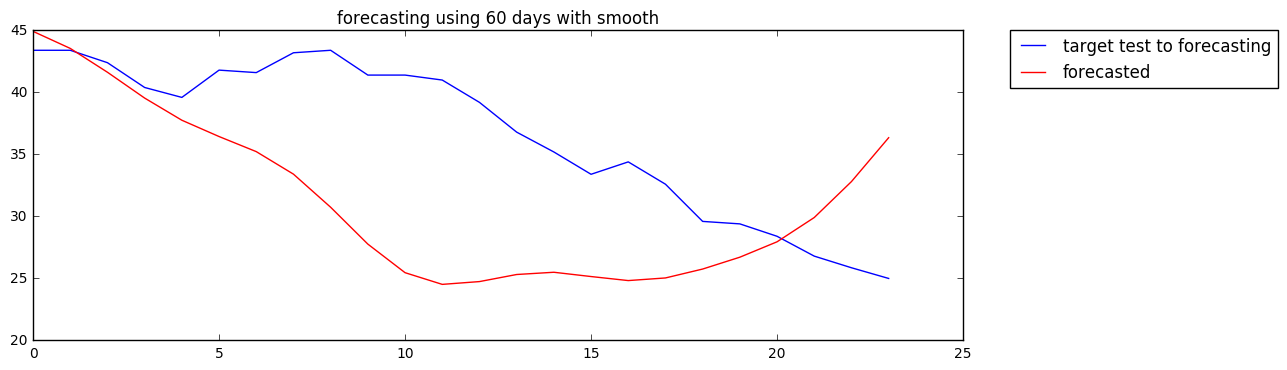

In [186]:
# r2 score obtained in forecasting
print("r2 score = ",r2_score(testY[:24], result))

# forecasting results
# shift train predictions for plotting
testPredictPlot = np.empty((int(testY[:24].shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot[0:len(testY[:24])+look_back] = result

# plot knn forecasted values and test for validation 
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[:24],color='b',label='target test to forecasting')
plt.plot(testPredictPlot,color='r', label='forecasted')
plt.title('forecasting using 60 days with smooth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()